Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..9.81830334560877].


nan
[0.         0.         0.95275097]


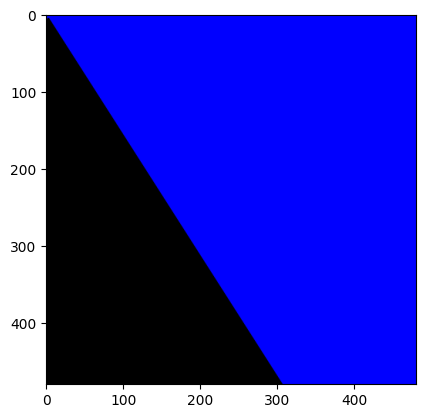

In [67]:
import grn
import numpy as np
import matplotlib.pyplot as plt


g = grn.GRN()
nin = 2
nout = 3

g.random(nin=nin, nout=nout, nreg=0)

N = 480


matrix = np.zeros((N,N,3))

for i in range(N):
    for j in range(N):
        g.set_input([i, j])
        g.step()   
        out = g.get_output()
        # if max(out) > 1:
        #     print("wtf")
        # print(out)
        matrix[i][j] = out


print(np.max(matrix[0][0]))
plt.imshow(matrix*10)

print(out)
# plt.savefig("test.png")

1.0

In [ ]:
str(g)
g.dict_grn# to end 
# for key in g.dict_grn:
#     print(g.dict_grn[key], end=" ")
genome = [2, 3, 0, 0.6796434914575574, 1.0830441520084637, 0, 1, 1, 0.68140467, 0.05245502, 0.72377252 ,0.38260298, 0.9576984, 0.22415276, 0.18545691, 0.04441582, 0.88123756, 0.69290689] 
[in, out, reg, beta, delta, a, f, idsize, identifiers, enhancers, inhibiters]
print(genome)

tg = grn.GRN()
tg.from_genome(genome)

[2, 3, 0, 0.6796434914575574, 1.0830441520084637, 0, 1, 1, 0.68140467, 0.05245502, 0.72377252, 0.38260298, 0.9576984, 0.22415276, 0.18545691, 0.04441582, 0.88123756, 0.69290689]


ValueError: cannot compute fingerprint of empty list